# Analysis code for the "First, you need a Gestalt: an interaction of bottom-up and top-down streams during perception of an ambiguously rotating human walker" maniscript.

In [1]:
import pandas as pd
import numpy as np
import os
from scipy.stats import sem, spearmanr, ttest_ind, ranksums
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
from mne.stats import permutation_t_test
from IPython.display import display
%matplotlib inline

Loading data of the main experiment into the single table. For information about data format please see [README.md](README.md)

In [20]:
### loading all results into a single table
group_folders= ['Naïve', 'Informed']
observers_in_learning_experiment= ['sd', 'tk', 'tw']
observers_in_learning_experiment= ['n11', 'n15', 'n18']

results= None
for current_group in group_folders: 
    csvFiles= os.listdir(current_group)

    for current_filename in csvFiles:
        if current_filename[-4:]=='.csv':
            current_observer= pd.read_csv(os.path.join(current_group, current_filename), sep=';', decimal='.', index_col=0)
            current_observer['Group']= current_group
            if results is None:
                results= current_observer
            else:
                results= pd.concat([results, current_observer])
            
## removing the training block 0
results= results[results.Block!=0]

## Computing a fraction of the time that observers reported perception of illusory rotation

In [21]:
### computing fraction of time for rotation percept for each observer x condition
perceived_rotation= results.groupby(by=['Observer', 'Condition']).apply(lambda x: pd.Series({
            'Group': x.Group.values[0],
            'VisibleTimeFraction': x.Duration.sum()/x['Block duration'].values[0]})).reset_index()

## adding missing conditions (no percept means VisibleTimeFraction= 0, but also means that the condition is missing in the aggregation)
missing_rows= None
for current_observer in perceived_rotation.Observer.unique():
    for current_condition in perceived_rotation.Condition.unique():
        if len(perceived_rotation[(perceived_rotation.Observer==current_observer) & (perceived_rotation.Condition==current_condition)])==0:
            # adding a missing row
            observer_group= perceived_rotation.Group[perceived_rotation.Observer==current_observer].values[0]
            missing_condition= pd.DataFrame({'Observer': current_observer,
                                             'Condition': current_condition,
                                             'Group': observer_group,
                                             'VisibleTimeFraction': 0.0}, index= [0])
            if missing_rows is None:
                missing_rows= missing_condition
            else:
                missing_rows= pd.concat([missing_rows, missing_condition])
perceived_rotation= pd.concat([perceived_rotation, missing_rows]).reset_index(drop= True)

## doing a logit transformation for the analysis
logit_boundaries_correction_value= 0.00001
perceived_rotation['Logit_VisibleTimeFraction']= np.log((perceived_rotation.VisibleTimeFraction+logit_boundaries_correction_value)/(1+logit_boundaries_correction_value-perceived_rotation.VisibleTimeFraction))

### computing group and condition averages
group_perception= perceived_rotation.groupby(['Group', 'Condition']).apply(lambda x: pd.Series({
        'visibility_mean': x.VisibleTimeFraction.mean(),
        'visibility_sem': sem(x.VisibleTimeFraction)   
        })).reset_index()

Summary statistics used in the text.

In [22]:
print('Scrambled static')
for current_group in group_folders:
    print('  %s. %d observers perceived rotation for more than 90%% of time'%(current_group,
        len(perceived_rotation[(perceived_rotation.Condition=='Scrambled static') & 
                           (perceived_rotation.VisibleTimeFraction>0.9) & 
                           (perceived_rotation.Group==current_group)])))
print('Inverted walker')
for current_group in group_folders:
    print('  %s. %d observers perceived rotation for more than 80%% of time'%(current_group,
        len(perceived_rotation[(perceived_rotation.Condition=='Inverted walker') & 
                           (perceived_rotation.VisibleTimeFraction>0.8) & 
                           (perceived_rotation.Group==current_group)])))

Scrambled static
  Naïve. 15 observers perceived rotation for more than 90% of time
  Informed. 14 observers perceived rotation for more than 90% of time
Inverted walker
  Naïve. 0 observers perceived rotation for more than 80% of time
  Informed. 10 observers perceived rotation for more than 80% of time


Plotting __figure 1A__. 

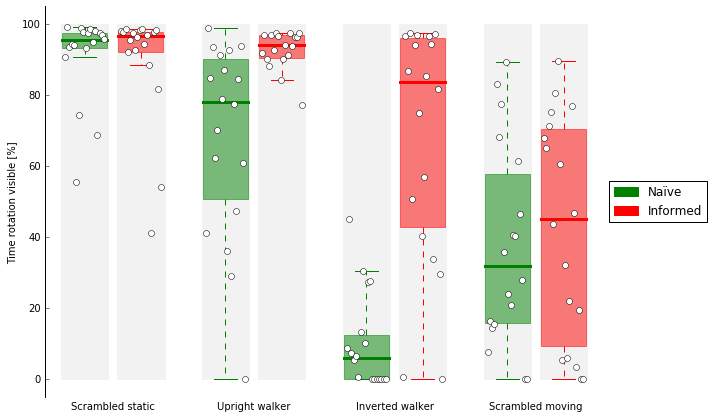

In [42]:
### plotting group averages along with the data from individual observers
condition_order= ['Scrambled static', 'Upright walker', 'Inverted walker', 'Scrambled moving']
group_order= ['Naïve', 'Informed']
group_marker= ['o', 'o']
group_color= ['green', 'red']
stripe_width= 1.4
matplotlib.rcParams['figure.figsize'] = (10.0, 7.0)
ax= plt.subplot(111)
legend_handles= []
for iCondition, current_condition in enumerate(condition_order):
    for iGroup, current_group in enumerate(group_order):
        # group mean and SEM
        iGroupConditionRow= group_perception[(group_perception.Condition==current_condition) & 
                                             (group_perception.Group==current_group)].index
        
        # grey background stripe that visually groups the data
        plt.fill_between(iCondition*5+iGroup*2+stripe_width*np.array([-0.6, 0.6]),
                         [0,0], [100,100], color='#f2f2f2', alpha=1)
        
        individual_observers= perceived_rotation.VisibleTimeFraction[(perceived_rotation.Condition==current_condition) &
                                                                     (perceived_rotation.Group==current_group)].values

        # computing stats for the box plot
        current_bp= plt.boxplot(100*(individual_observers), 
                    bootstrap= 10000,
                    positions= [iCondition*5+iGroup*2], 
                    widths= [1.6],
                    showfliers=False,
                    patch_artist=True)
        plt.setp(current_bp['boxes'], color=group_color[iGroup], alpha= 0.5)
        plt.setp(current_bp['medians'], color=group_color[iGroup], linewidth= 3)
        plt.setp(current_bp['whiskers'], color=group_color[iGroup])
        plt.setp(current_bp['caps'], color=group_color[iGroup])
        
        # individual observers
        plt.plot(iCondition*5+iGroup*2-stripe_width/2+stripe_width*np.arange(len(individual_observers))/(len(individual_observers)-1),
                 100*individual_observers, 
                 group_marker[iGroup],
                 color= 'white')
        
        # marking out learning experiment observers (if found)
        observer_ids= perceived_rotation.Observer[(perceived_rotation.Condition==current_condition) &
                                                  (perceived_rotation.Group==current_group)].values

for iGroup, current_group in enumerate(group_order):
    legend_handles.append(mpatches.Patch(color=group_color[iGroup], label=group_order[iGroup]))

plt.ylabel('Time rotation visible [%]')
plt.xticks(np.arange(len(condition_order))*5+1, condition_order)
plt.axis([-stripe_width, (len(condition_order)-1)*5+2+stripe_width, -5, 105])
plt.legend(handles= [legend_handles[0], legend_handles[1]], 
           labels= [group_order[0], group_order[1]], loc='center left', bbox_to_anchor=(1, 0.5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('none')
plt.show() #savefig('rotation.svg')

Performing a pairwise statistical comparison between groups within conditions, __Between__ subtable in __Figure 1a__.

In [24]:
## An implementation of the permutation t-test on independent samples
def ttest_ind_perm(a, b, iterationsN=10000):
    # first, computing default values
    default_tstat, default_p= ttest_ind(a, b, equal_var=False)
    
    # shuffling all values together
    ab= np.concatenate([a,b])
    shuffle_tstat= np.zeros((iterationsN, ))
    for iIt in range(iterationsN):
        np.random.shuffle(ab)
        shuffle_tstat[iIt], not_interesting_p= ttest_ind(ab[:len(a)], ab[len(a):])

    pvalue_from_permutation= np.sum(default_tstat<shuffle_tstat)/iterationsN
    if pvalue_from_permutation>0.5:
        pvalue_from_permutation= 1-pvalue_from_permutation

    return (default_tstat, default_p, pvalue_from_permutation)

In [25]:
## An implementation of the permutation t-test on independent samples
def nonparam_ind_perm(a, b, iterationsN=10000):
    # first, computing default values
    default_delta= np.mean(a)-np.mean(b)
    
    # shuffling all values together
    ab= np.concatenate([a,b])
    shuffle_delta= np.zeros((iterationsN, ))
    for iIt in range(iterationsN):
        np.random.shuffle(ab)
        shuffle_delta[iIt]= np.mean(ab[:len(a)])-np.mean(ab[len(a):])

    pvalue_from_permutation= np.sum(default_delta<shuffle_delta)/iterationsN
    if pvalue_from_permutation>0.5:
        pvalue_from_permutation= 1-pvalue_from_permutation

    return (pvalue_from_permutation)

In [26]:
## comparison between groups
tstat= np.zeros((len(condition_order), ))
DFs= np.zeros((len(condition_order), ))
pvalue= np.zeros((len(condition_order), ))
Rs= np.zeros((len(condition_order), ))
non_param_p= np.zeros((len(condition_order), ))
p_perm= np.zeros((len(condition_order), ))
wstat= np.zeros((len(condition_order), ))
pranksum= np.zeros((len(condition_order), ))
for iC, current_condition in enumerate(condition_order):
    
    naive_group= perceived_rotation.Logit_VisibleTimeFraction[(perceived_rotation.Group=='Naïve') &
                                                     (perceived_rotation.Condition==current_condition)].values
    informed_group= perceived_rotation.Logit_VisibleTimeFraction[(perceived_rotation.Group=='Informed') &
                                                     (perceived_rotation.Condition==current_condition)].values
    tstat[iC], pvalue[iC], p_perm[iC]= ttest_ind_perm(naive_group, informed_group)

    # Сomputing degrees of freedom via a Welch-Satterthwaite equation.
    naive_n= len(naive_group)
    naive_var= np.var(naive_group, ddof=1)
    informed_n= len(informed_group)
    informed_var= np.var(informed_group, ddof=1)
    DFs[iC] = ((naive_var/naive_n + informed_var/informed_n)**(2.0))/((naive_var/naive_n)**(2.0)/(naive_n-1) + (informed_var/informed_n)**(2.0)/(informed_n-1)) 
    Rs[iC]= np.sqrt(np.power(tstat[iC], 2)/ (np.power(tstat[iC], 2)+DFs[iC]))
    
    # non-parametric permutation based on mean difference only
    non_param_p[iC]= nonparam_ind_perm(naive_group, informed_group)
        
    # not-parametric Wilcoxon rank sums
    wstat[iC], pranksum[iC]= ranksums(naive_group, informed_group)
    
correctedP= multipletests(pvalue)[1]
correctedPerm= multipletests(p_perm)[1]
correctecPrank= multipletests(pranksum)[1]
reported_time_comparison= pd.DataFrame({'t-stat': tstat, 
                                        'df': DFs,
                                        'corrected permutation t-test p-value': correctedPerm,
                                        'effect size': Rs,
                                        'non-param p-value': non_param_p, 
                                        'w-stat': wstat,
                                        'corrected ranksum p-value': correctecPrank}, 
                                       columns= ['t-stat', 'df', 'corrected permutation t-test p-value', 'effect size', 'non-param p-value', 'w-stat', 'corrected ranksum p-value'],
                                       index=condition_order)
display(reported_time_comparison)
reported_time_comparison.to_csv('mainexp-rotationfraction-betweengroups.csv', sep=';', decimal='.', index=False)

,t-stat,df,corrected permutation t-test p-value,effect size,non-param p-value,w-stat,corrected ranksum p-value
Scrambled static,0.078529,33.795332,0.691753,0.013507,0.4698,-0.094916,0.924382
Upright walker,-2.680139,18.663926,0.000900,0.527171,0.0003,-3.353692,0.002390
Inverted walker,-4.395393,31.942366,0.000400,0.613904,0.0000,-4.223753,0.000096
Scrambled moving,-0.092797,33.945061,0.691753,0.015925,0.4632,-0.411302,0.898144


## Time-to-first percept
__Figure 1b__ in the manuscript.

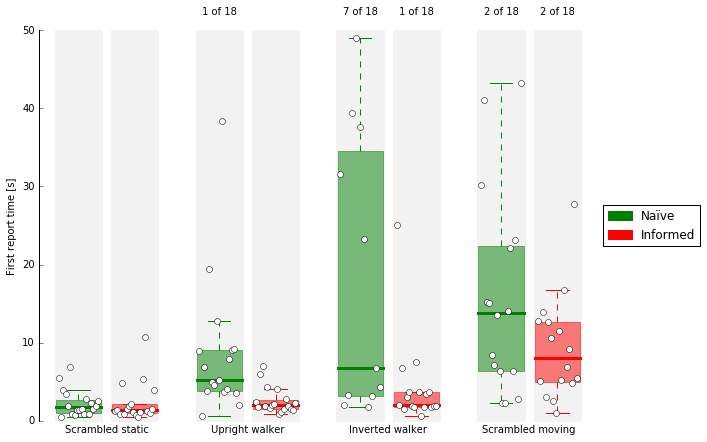

In [27]:
## settings
group_marker= ['o', 'o']
group_color= ['green', 'red']
stripe_width= 1.4
matplotlib.rcParams['figure.figsize'] = (10.0, 7.0)

## computing fraction of time for rotation percept for each observer x condition
first_onset= results.groupby(by=['Observer', 'Condition']).apply(lambda x: pd.Series({
            'Group': x.Group.values[0],
            'OnsetTime': x.Onset.min()})).reset_index()
top_of_the_plot= np.ceil(first_onset.OnsetTime.max()+1)


## plotting
ax= plt.subplot(111)
for iCondition, current_condition in enumerate(condition_order):
    for iGroup, current_group in enumerate(group_order):
        # group mean and SEM
        individual_observers= first_onset.OnsetTime[(first_onset.Condition==current_condition) &
                                                    (first_onset.Group==current_group)].values
        
        # grey background stripe that visually groups the data
        plt.fill_between(iCondition*5+iGroup*2+stripe_width*np.array([-0.6, 0.6]),
                         [0,0], [top_of_the_plot, top_of_the_plot], color='#f2f2f2', alpha=1)

        # box plot as summary statisics
        current_bp= plt.boxplot(individual_observers, 
                    bootstrap= 10000,
                    positions= [iCondition*5+iGroup*2], 
                    widths= [1.6],
                    showfliers=False,
                    patch_artist=True)
        plt.setp(current_bp['boxes'], color=group_color[iGroup], alpha= 0.5)
        plt.setp(current_bp['medians'], color=group_color[iGroup], linewidth= 3)
        plt.setp(current_bp['whiskers'], color=group_color[iGroup])
        plt.setp(current_bp['caps'], color=group_color[iGroup])
        
        # individual observers
        plt.plot(iCondition*5+iGroup*2-stripe_width/2+stripe_width*np.arange(len(individual_observers))/(len(individual_observers)-1),
                 individual_observers, 
                 group_marker[iGroup],
                 color= 'white')
        
        # writing number of observers without an onset (no percept at all)
        observers_in_the_group= len(first_onset.Observer[first_onset.Group==current_group].unique())
        if len(individual_observers)<observers_in_the_group:
            plt.text(iCondition*5+iGroup*2, 
                     top_of_the_plot+2, 
                     '%d of %d'%(observers_in_the_group-len(individual_observers), observers_in_the_group),
                     horizontalalignment='center')
        
        
plt.ylabel('First report time [s]')
plt.xticks(np.arange(len(condition_order))*5+1, condition_order)
plt.axis([-stripe_width, (len(condition_order)-1)*5+2+stripe_width, 0, top_of_the_plot])
plt.legend(handles= [legend_handles[0], legend_handles[1]], labels=group_order, loc='center left', bbox_to_anchor=(1, 0.5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('none')        
plt.show()

Summary statistics used in the text

In [12]:
print('Latest onset time for Scrambled Static: %.1f'%(first_onset[first_onset.Condition=='Scrambled static'].OnsetTime.max()))

print('Latest onset time for Upright Walker for Informed group: %.2f'%(
        first_onset[(first_onset.Condition=='Upright walker') & (first_onset.Group=='Informed')].OnsetTime.max()))

Latest onset time for Scrambled Static: 10.7
Latest onset time for Upright Walker for Informed group: 7.02


## Perceptual stability of rotation (geometric mean of perceptual dominance times)
__Figure 1c__ in the manuscript.

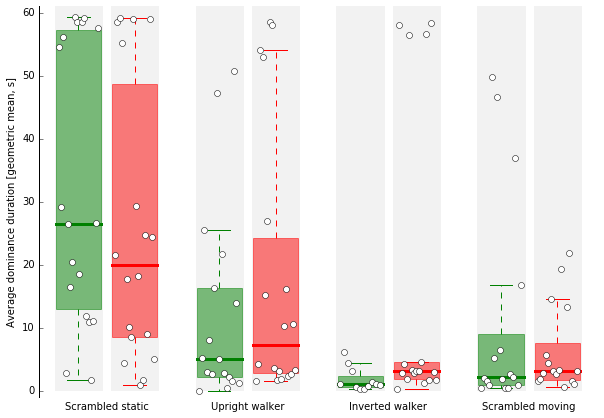

In [29]:
## settings
group_marker= ['o', 'o']
group_color= ['green', 'red']
stripe_width= 1.4
matplotlib.rcParams['figure.figsize'] = (10.0, 7.0)

## computing fraction of time for rotation percept for each observer x condition
median_duration= results.groupby(by=['Observer', 'Condition']).apply(lambda x: pd.Series({
            'Group': x.Group.values[0],
            'Duration': np.exp(np.mean(np.log(x.Duration)))})).reset_index()
top_of_the_plot= np.ceil(median_duration.Duration.max()+1)


## plotting
ax= plt.subplot(111)
for iCondition, current_condition in enumerate(condition_order):
    for iGroup, current_group in enumerate(group_order):
        # group mean and SEM
        individual_observers= median_duration.Duration[(median_duration.Condition==current_condition) &
                                                       (median_duration.Group==current_group)].values
        
        # grey background stripe that visually groups the data
        plt.fill_between(iCondition*5+iGroup*2+stripe_width*np.array([-0.6, 0.6]),
                         [0,0], [top_of_the_plot, top_of_the_plot], color='#f2f2f2', alpha=1)

        # box plot as summary statisics
        current_bp= plt.boxplot(individual_observers, 
                    bootstrap= 10000,
                    positions= [iCondition*5+iGroup*2], 
                    widths= [1.6],
                    showfliers=False,
                    patch_artist=True)
        plt.setp(current_bp['boxes'], color=group_color[iGroup], alpha= 0.5)
        plt.setp(current_bp['medians'], color=group_color[iGroup], linewidth= 3)
        plt.setp(current_bp['whiskers'], color=group_color[iGroup])
        plt.setp(current_bp['caps'], color=group_color[iGroup])
        
        # individual observers
        plt.plot(iCondition*5+iGroup*2-stripe_width/2+stripe_width*np.arange(len(individual_observers))/(len(individual_observers)-1),
                 individual_observers, 
                 group_marker[iGroup],
                 color= 'white')
        
plt.ylabel('Average dominance duration [geometric mean, s]')
plt.xticks(np.arange(len(condition_order))*5+1, condition_order)
plt.axis([-stripe_width, (len(condition_order)-1)*5+2+stripe_width, -1, 61])
# plt.legend(handles= [legend_handles[0], legend_handles[1]], labels=group_order, loc='center left', bbox_to_anchor=(1, 0.5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('none')        
plt.show()

## Comparing distribution of dominance times for inverted and upright walker for selected observers from Informed group (rotation reported >80% of the time)

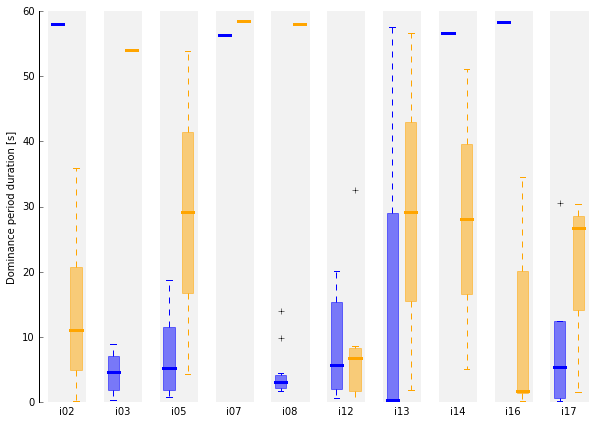

In [31]:
## getting a subset of observers who perceived rotation reliably in the inverted walker condition
reliable_observers= perceived_rotation.Observer[(perceived_rotation.Group=='Informed') & 
                                                (perceived_rotation.Condition=='Inverted walker') & 
                                                (perceived_rotation.VisibleTimeFraction>0.8)].unique()
condition_color= {'Inverted walker': 'blue', 'Upright walker': 'orange'}

## plotting distribution summary for each observer and condition
ax= plt.subplot(111)
for iO, current_observer in enumerate(reliable_observers):
    # grey background stripe that visually groups the data
    plt.fill_between(iO*3+0.5+np.array([-1, 1]),
                         [0,0], [100,100], color='#f2f2f2', alpha=1)
      
    for iC, current_condition in enumerate(['Inverted walker', 'Upright walker']):
        current_dominance_periods= results.Duration[(results.Observer==current_observer) &
                                                    (results.Condition==current_condition)].values
        # box plot
        current_bp= plt.boxplot(current_dominance_periods,
                    positions= [iC+iO*3],
                    widths= [0.6],
                    patch_artist=True)
        plt.setp(current_bp['boxes'], color=condition_color[current_condition], alpha= 0.5)
        plt.setp(current_bp['medians'], color=condition_color[current_condition], linewidth= 3)
        plt.setp(current_bp['whiskers'], color=condition_color[current_condition])
        plt.setp(current_bp['caps'], color=condition_color[current_condition])
        
#                         bootstrap= 10000,
#                         positions= [iC+iO*3]) 
#                         patch_artist=True)
    
plt.ylabel('Dominance period duration [s]')
plt.xticks(np.arange(len(reliable_observers))*3+0.5, reliable_observers)
plt.axis([-1, len(reliable_observers)*3-1, 0, 60])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('none')
plt.show()


# 2. Experiment 2:  Effect of perceptual learning

In [32]:
### loading results
condition_color= {'Inverted walker': 'blue', 'Upright walker': 'orange'}
learning= None
csvFiles= os.listdir('Learning')

for current_filename in csvFiles:
    if current_filename[-4:]=='.csv':
        current_observer= pd.read_csv(os.path.join('Learning', current_filename), sep=';', decimal='.', index_col=0)
        if learning is None:
            learning= current_observer
        else:
            learning= pd.concat([learning, current_observer])

### computing all relevant observables
learning_summary= learning.groupby(by=['Observer', 'Condition', 'Block']).apply(lambda x: pd.Series({
            'SessionID': x.SessionID.values[0],
            'VisibleTimeFraction': x.Duration.sum()/x['Block duration'].values[0],
            'DominanceGeoMean': np.exp(np.mean(np.log(x.Duration))),
            'DominanceGeoStdLo': np.exp(np.mean(np.log(x.Duration)))-np.exp(np.std(np.log(x.Duration))),
            'DominanceGeoStdHi': np.exp(np.mean(np.log(x.Duration)))+np.exp(np.std(np.log(x.Duration))),
            'FirstReportTime': x.Onset.min()})).reset_index()

 ## 2.1 Effect of perceptual learning on time of reported rotation

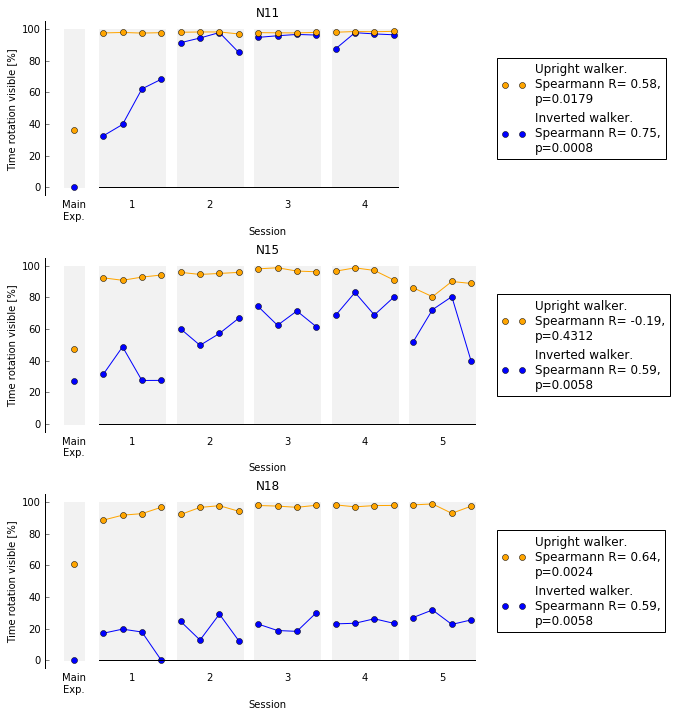

In [37]:
### plotting fraction of time that observers reported rotation per session
matplotlib.rcParams['figure.figsize'] = (7.0, 10.0)
for iO, current_observer in enumerate(observers_in_learning_experiment):

    # subplot for the experimental data and fit
    ax= plt.subplot(len(observers_in_learning_experiment), 1, iO+1)    
    
    # data from the main experiment (which was session #0)
    plt.fill_between([-2, -1], [0,0], [100, 100], color='#f2f2f2', alpha=1)
    plt.title(current_observer.upper())
    legend_handles= []
    legend_text= []
    for current_condition in ['Upright walker', 'Inverted walker']:
        main_exp_rotation= perceived_rotation.VisibleTimeFraction[(perceived_rotation.Observer==current_observer) &
                                                                  (perceived_rotation.Condition==current_condition)].values
        
        # computing Spearman's correlation to evaluate learning effect
        condition_rotation= learning_summary.VisibleTimeFraction[(learning_summary.Observer==current_observer) &
                                                        (learning_summary.Condition==current_condition)].values
        rho, pvalue= spearmanr(np.arange(len(condition_rotation)), condition_rotation)

        current_plot, = plt.plot([-1.5], 
                 main_exp_rotation*100, 'o', 
                 color= condition_color[current_condition])
        legend_handles.append(current_plot)
        legend_text.append('%s.\nSpearmann R= %.2f,\np=%.4f'%(current_condition, rho, pvalue))
    plt.legend(legend_handles, legend_text, loc='center left', bbox_to_anchor=(1, 0.5))
        
        
    xTicks= [-1.5]
    xTicksLabel= ['Main\nExp.']

    # plotting data per session 
    for iSession, current_session in enumerate(learning_summary.SessionID[learning_summary.Observer==current_observer].unique()):
        xTicks.append(iSession*4+1.5)
        xTicksLabel.append('%d'%(iSession+1))
        
        # grey background stripe that visually groups the data
        plt.fill_between(iSession*4+np.array([-0.2, 3.2]),
                         [0,0], [100, 100], color='#f2f2f2', alpha=1)
        
        for current_condition in ['Inverted walker', 'Upright walker']:
            current_rotation= learning_summary.VisibleTimeFraction[(learning_summary.Observer==current_observer) &
                                                                   (learning_summary.SessionID==current_session) & 
                                                                   (learning_summary.Condition==current_condition)].values
            plt.plot(iSession*4+np.arange(len(current_rotation)), 
                     current_rotation*100, 'o-', 
                     color= condition_color[current_condition])
            

    # prettify
    session_count= len(learning_summary.SessionID[learning_summary.Observer==current_observer].unique())
    plt.plot([-0.2, (session_count-1)*4+3.2], [0,0], 'k-')
    plt.axis([-3, 20, -5, 105])
    plt.xticks(xTicks, xTicksLabel)
    plt.xlabel('Session')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('none')
    plt.ylabel('Time rotation visible [%]')


plt.tight_layout()
plt.show()

 ## 2.2 Effect of perceptual learning on median percept duration

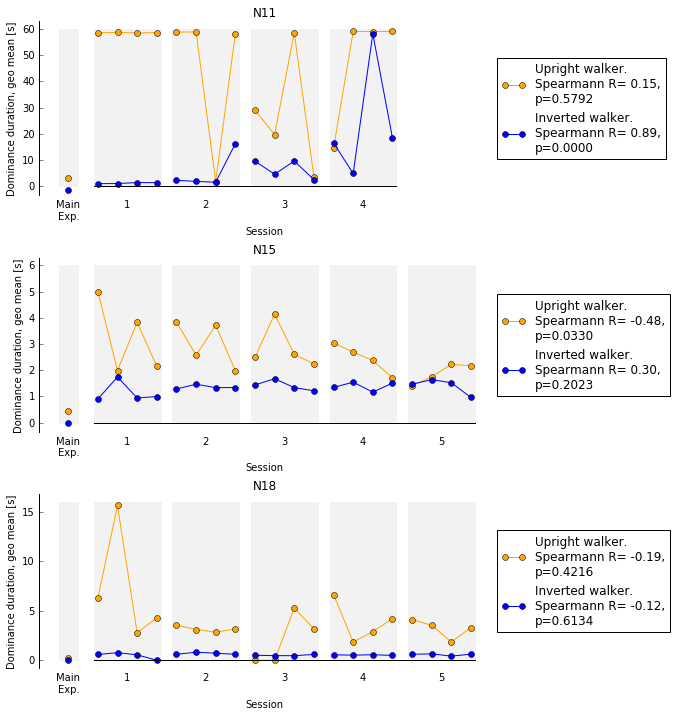

In [35]:
### plotting an average (geometric mean) of dominance periods
matplotlib.rcParams['figure.figsize'] = (7.0, 10.0)
for iO, current_observer in enumerate(observers_in_learning_experiment):

    # subplot for the experimental data and fit
    ax= plt.subplot(len(observers_in_learning_experiment), 1, iO+1)    
    
    # data from the main experiment (which was session #0)
    plt.title(current_observer.upper())
    legend_handles= []
    legend_text= []
    for current_condition in ['Upright walker', 'Inverted walker']:
        main_exp_dominance= results.Duration[(results.Observer==current_observer) &
                                             (results.Condition==current_condition)].values
        if len(main_exp_dominance)==0:
            main_exp_geomean= 0
        else:
            main_exp_geomean= np.mean(np.log(main_exp_dominance+0.0001))
        
        current_plot, = plt.plot([-1.5], 
                                 [main_exp_geomean], 'o', 
                                 color= condition_color[current_condition])
        
        
        
        # computing Spearman's correlation to evaluate learning effect
        condition_dominance= learning_summary.DominanceGeoMean[(learning_summary.Observer==current_observer) &
                                                        (learning_summary.Condition==current_condition)].values
        rho, pvalue= spearmanr(np.arange(len(condition_dominance)), condition_dominance)
        legend_text.append('%s.\nSpearmann R= %.2f,\np=%.4f'%(current_condition, rho, pvalue))
        
        
    xTicks= [-1.5]
    xTicksLabel= ['Main\nExp.']

    # plotting data per session
    observer_sessions= learning_summary.SessionID[learning_summary.Observer==current_observer].unique()
    for iSession, current_session in enumerate(observer_sessions):
        xTicks.append(iSession*4+1.5)
        xTicksLabel.append('%d'%(iSession+1))
        
        # grey background stripe that visually groups the data
#         plt.fill_between(iSession*4+np.array([-0.2, 3.2]),
#                          [0,0], [60, 60], color='#f2f2f2', alpha=1)
        
        for current_condition in ['Upright walker', 'Inverted walker']:
            iCurrentSession= learning_summary[(learning_summary.Observer==current_observer) &
                                                            (learning_summary.SessionID==current_session) & 
                                                            (learning_summary.Condition==current_condition)].index
            current_mean= learning_summary.DominanceGeoMean[iCurrentSession].values
            current_plot, = plt.plot(iSession*4+np.arange(len(current_rotation)), 
                     current_mean, 'o-', 
                     color= condition_color[current_condition])
            
            if iSession==0:
                legend_handles.append(current_plot)
            
            

    # prettify
    plt.legend(legend_handles, legend_text, loc='center left', bbox_to_anchor=(1, 0.5))
    session_count= len(learning_summary.SessionID[learning_summary.Observer==current_observer].unique())
    plt.plot([-0.2, (session_count-1)*4+3.2], [0,0], 'k-')
    current_axis= plt.axis()
    
    plt.fill_between([-2, -1], [0,0], [current_axis[3], current_axis[3]], color='#f2f2f2', alpha=1)
    for iSession, current_session in enumerate(observer_sessions):
        plt.fill_between(iSession*4+np.array([-0.2, 3.2]),
                         [0,0], [current_axis[3], current_axis[3]], color='#f2f2f2', alpha=1)    
        
    plt.axis([-3, 20, -(current_axis[3]-current_axis[2])*0.05, 1.05*current_axis[3]])
    plt.xticks(xTicks, xTicksLabel)
    plt.xlabel('Session')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('none')
    plt.ylabel('Dominance duration, geo mean [s]')


plt.tight_layout()
plt.show()

 ## 2.3 Effect of perceptual learning on first percept time

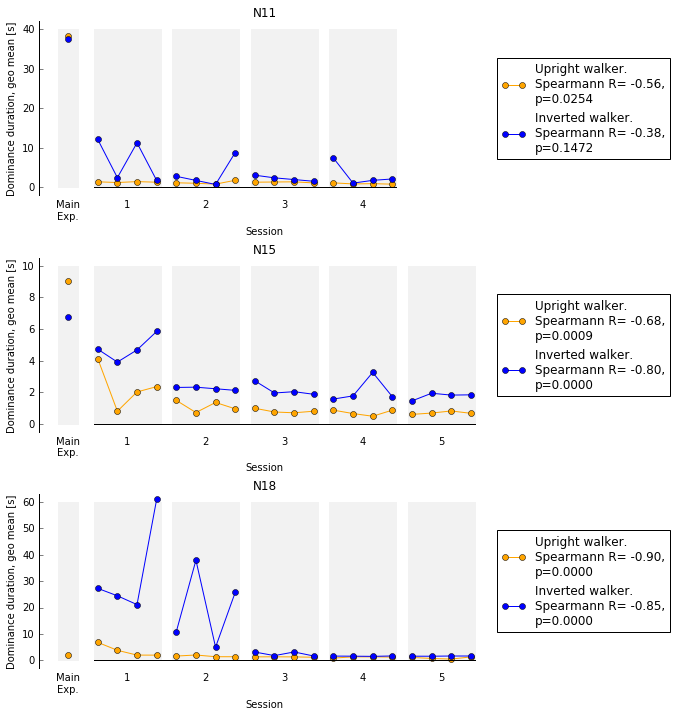

In [36]:
### plotting the first percept time
matplotlib.rcParams['figure.figsize'] = (7.0, 10.0)
for iO, current_observer in enumerate(observers_in_learning_experiment):

    # subplot for the experimental data and fit
    ax= plt.subplot(len(observers_in_learning_experiment), 1, iO+1)    
    
    # data from the main experiment (which was session #0)
    plt.title(current_observer.upper())
    legend_handles= []
    legend_text= []
    for current_condition in ['Upright walker', 'Inverted walker']:
        main_exp_onset= results.Onset[(results.Observer==current_observer) &
                                             (results.Condition==current_condition)].values
        if len(main_exp_onset)==0:
            main_exp_onset= [70] # outside of view
        
        current_plot, = plt.plot([-1.5], 
                                 [main_exp_onset[0]], 'o', 
                                 color= condition_color[current_condition])
        
        
        
        # computing Spearman's correlation to evaluate learning effect
        condition_onset= learning_summary.FirstReportTime[(learning_summary.Observer==current_observer) &
                                                        (learning_summary.Condition==current_condition)].values
        rho, pvalue= spearmanr(np.arange(len(condition_onset)), condition_onset)
        legend_text.append('%s.\nSpearmann R= %.2f,\np=%.4f'%(current_condition, rho, pvalue))
        
        
    xTicks= [-1.5]
    xTicksLabel= ['Main\nExp.']

    # plotting data per session
    observer_sessions= learning_summary.SessionID[learning_summary.Observer==current_observer].unique()
    for iSession, current_session in enumerate(observer_sessions):
        xTicks.append(iSession*4+1.5)
        xTicksLabel.append('%d'%(iSession+1))
        
        # grey background stripe that visually groups the data
#         plt.fill_between(iSession*4+np.array([-0.2, 3.2]),
#                          [0,0], [60, 60], color='#f2f2f2', alpha=1)
        
        for current_condition in ['Upright walker', 'Inverted walker']:
            iCurrentSession= learning_summary[(learning_summary.Observer==current_observer) &
                                                            (learning_summary.SessionID==current_session) & 
                                                            (learning_summary.Condition==current_condition)].index
            current_mean= learning_summary.FirstReportTime[iCurrentSession].values
            current_plot, = plt.plot(iSession*4+np.arange(len(current_rotation)), 
                     current_mean, 'o-', 
                     color= condition_color[current_condition])
            
            if iSession==0:
                legend_handles.append(current_plot)
            
            

    # prettify
    plt.legend(legend_handles, legend_text, loc='center left', bbox_to_anchor=(1, 0.5))
    session_count= len(learning_summary.SessionID[learning_summary.Observer==current_observer].unique())
    plt.plot([-0.2, (session_count-1)*4+3.2], [0,0], 'k-')
    current_axis= plt.axis()
    max_y= np.min([current_axis[3], 60])
    
    plt.fill_between([-2, -1], [0,0], [max_y, max_y], color='#f2f2f2', alpha=1)
    for iSession, current_session in enumerate(observer_sessions):
        plt.fill_between(iSession*4+np.array([-0.2, 3.2]),
                         [0,0], [max_y, max_y], color='#f2f2f2', alpha=1)    
        
    plt.axis([-3, 20, -(max_y-current_axis[2])*0.05, 1.05*max_y])
    plt.xticks(xTicks, xTicksLabel)
    plt.xlabel('Session')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('none')
    plt.ylabel('Dominance duration, geo mean [s]')


plt.tight_layout()
plt.show()